In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from math import floor

import altair as vg
import numpy as np
import joblib
import pandas as pd
from sklearn.metrics import adjusted_rand_score
from IPython.display import display, Markdown

from meli.common import get_base_path
from meli.visualization.bar import bar, histogram
from meli.modeling.clustering import make_dimensionality_reduction_pipeline
from meli.analysis.rna_seq.visualization import (
    report_pca_results, make_default_clustering_pipeline)
from meli.analysis.rna_seq.classification import (
    make_baseline, report_multivariate_classification_metrics, 
    report_classification)

In [3]:
PROBLEM = 'rna_seq'

base_path = get_base_path()
data_path = os.path.join(base_path, f'data/{PROBLEM}')

# Data Loading and some Exploration

In [4]:
cell_class = 'cell_class'

develop_fp = os.path.join(data_path, 'develop.parquet')
develop = pd.read_parquet(develop_fp)
develop.head()

cell_class    1    2    3    4    5    6         7         8    9  ...  \
848           15  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.499395  0.0  ...   
139            2  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  ...   
1633          24  0.0  0.0  0.0  0.0  0.0  0.0  1.051521  0.000000  0.0  ...   
1764          27  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  ...   
1065          17  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  ...   

          19991      19992       19993       19994     19995       19996  \
848   73.411026  14.981842   30.463079    0.000000  1.498184   94.385605   
139   84.933559  11.839223  128.687210    0.000000  0.000000  193.030815   
1633  12.618257   6.309128  178.758637  266.034913  0.000000   87.276276   
1764  43.675246   5.780547  145.798249   77.716247  1.284566   34.683284   
1065   0.000000   9.372243   75.915164  131.211395  0.937224    0.000000   

          19997       19998       19999       20000  
848    0.000000    0.000000   61.924947  220.233078  
139    0.000000  275.905379  144.129676  356.206198  
1633  33.648685   86.750515   35.751727  213.984604  
1764   0.642283   75.789398   38.536982  276.181704  
1065   0.000000  240.398020   60.919576  344.429912  

[5 rows x 20001 columns]

## Distribution of Classes 

In [5]:
histogram(develop[cell_class], 'Distribution of Cell Types')

alt.Chart(...)

# Baseline Classification Model

## Check for any single variable that is too informative (and might be a leak)

Here we try and assess if any gene expression variable is "too informative" by abusing clustering metrics a little.
Adjusted Rand Index close to 1 would imply that few of our variables already provide a pretty good description of the cell class, hence we could probably use a classifier with only a couple of variables.

This is left commented out to avoid producing a large warning message.

## Build a Classification Model

From our exploration of the unlabeled data, we know that not many of the principal components represent a significant portion of the data's variance. 
In that case, we had ~1800 components to represent 95% of the variance. 
Here, we can take a step towards avoiding overfitting by selecting only a handful of components. 
We'll take only the components that represent at least 0.1% of the variance.

In [6]:
X = develop.drop([cell_class], axis=1)
y = develop[cell_class]

### Number of Informative PCA Components

In [7]:
pca = make_dimensionality_reduction_pipeline(0.95)
pca.fit(X)
report_pca_results(pca['pca'])

### Baseline Classifier Fit

Let's use a simple nearest-neighbors classifier as a Baseline.

We've seen in our visualization efforts that the data shows some spatial patterns and that may be captured here using the same distance metric.

In [8]:
classifier_path = os.path.join(data_path, 'baseline-classifier.joblib')
metrics_path = os.path.join(data_path, 'baseline-classifier-metrics.parquet')

clf = make_baseline()
metrics = report_multivariate_classification_metrics(clf, X, y)
metrics.to_parquet(metrics_path)

clf.fit(X, y)
joblib.dump(clf, classifier_path)
print(clf)
metrics.style

Pipeline(steps=[('dimensionality_reduction',
                 Pipeline(steps=[('log1p',
                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                 ('scaling', StandardScaler(with_std=False)),
                                 ('pca',
                                  PCA(n_components=50,
                                      random_state=480022681))])),
                ('scaling', StandardScaler()),
                ('classifier',
                 KNeighborsClassifier(metric=<function cosine at 0x7fb9357728b0>,
                                      n_jobs=-1, weights='distance'))])


## Performance

### Performance over Fit Data


    Model Performance:

    F1-Score (Micro): 1.0
    F1-Score (Macro): 1.0
    


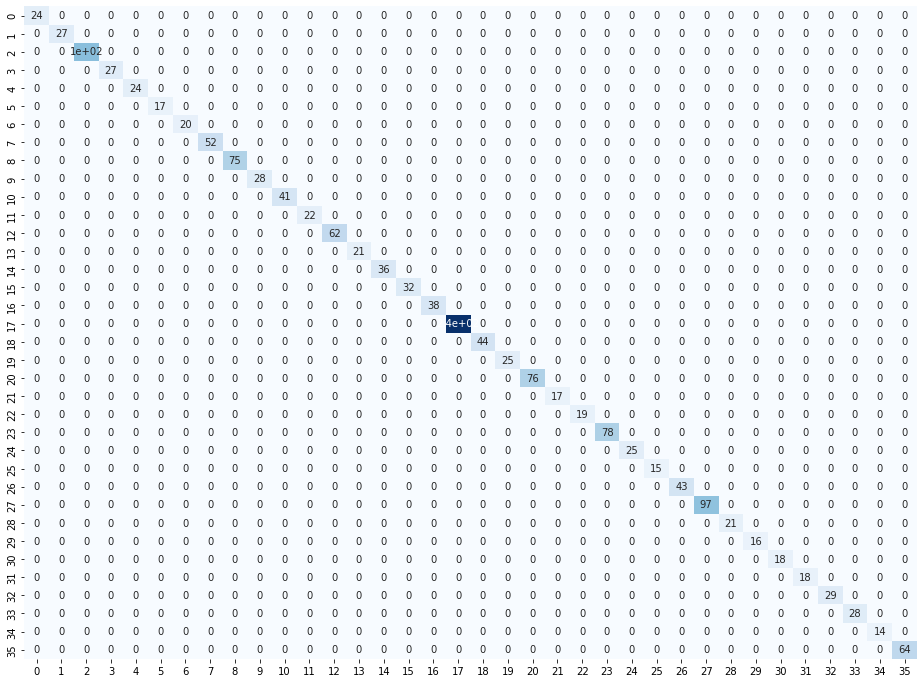

In [9]:
y_pred = clf.predict(X)
report_classification(y, y_pred)

### Performance over Evaluation (held-out) Data


    Model Performance:

    F1-Score (Micro): 0.9603053435114504
    F1-Score (Macro): 0.9460578766491952
    


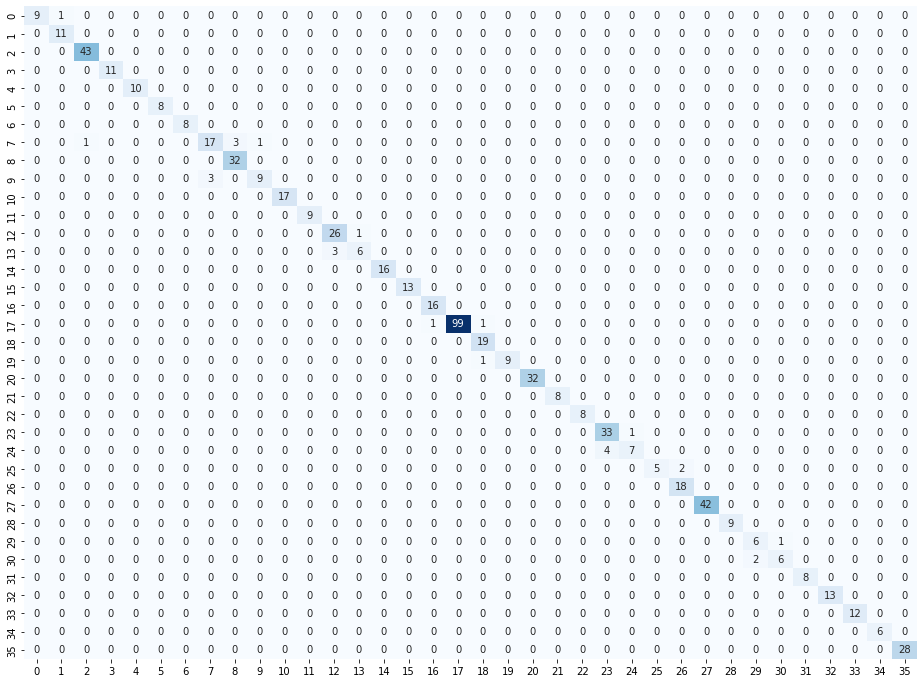

In [10]:
evaluation_fp = os.path.join(data_path, 'evaluation.parquet')
evaluation = pd.read_parquet(evaluation_fp)
y_true_test = evaluation[cell_class]
X_test = evaluation.drop([cell_class], axis=1)

y_pred_test = clf.predict(X_test)
report_classification(y_true_test, y_pred_test)